<a href="https://colab.research.google.com/github/hyehyunseo/ESAA_OB/blob/main/xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [3]:
plt.rc('font', family='NanumBarunGothic') # matplotlib 한글 깨짐 방지

* 데이터 불러오기

In [4]:
train = pd.read_csv('/content/drive/MyDrive/ESAA/OB/project/mproject1/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/ESAA/OB/project/mproject1/data/test.csv')

In [5]:
train.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,0.472227,-1.756525,0.734336,9.126398,1,0,1,0,0,1,0,0
1,0.543313,-1.033082,-0.911192,9.052009,1,0,1,0,1,0,0,0
2,0.898745,-0.943687,-0.911192,10.207990,1,0,1,0,0,0,1,0
3,-0.025379,0.622393,3.202629,9.059265,1,0,1,0,0,0,1,0
4,1.040918,-1.504893,1.557100,9.431590,1,0,1,0,0,1,0,0


In [6]:
test.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,0.401140,-0.891539,0.734336,9095.06825,1,0,1,0,1,0,0,0
1,-0.238638,-0.089461,-0.911192,5272.17580,1,0,1,0,0,1,0,0
2,1.751782,-0.608453,-0.911192,29330.98315,1,0,0,1,0,1,0,0
3,0.472227,-0.797177,1.557100,9301.89355,0,1,1,0,0,1,0,0
4,-1.447107,0.225079,-0.911192,33750.29180,0,1,0,1,0,1,0,0


In [7]:
# feature / target 분리
X_train = train.drop(['charges'], axis = 1)
y_train = train['charges']

X_test = test.drop(['charges'], axis = 1)
y_test = test['charges']

## **XGBoost modeling**

In [8]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, learning_curve
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, make_scorer

* grid search

In [9]:
# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# XGBoost 회귀 모델 생성
xgb = XGBRegressor()

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 찾기
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           scoring=make_scorer(mean_squared_error, greater_is_better=False), cv=3)
grid_search.fit(X_train, y_train)

# 최적의 파라미터 출력
print("최적의 하이퍼파라미터:", grid_search.best_params_)

최적의 하이퍼파라미터: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100}


* model fitting

In [10]:
# 최적의 파라미터로 모델 생성
best_xgb = grid_search.best_estimator_

# 모델 학습
best_xgb.fit(X_train, y_train)

# 검증 데이터 예측
y_pred = best_xgb.predict(X_test)
y_pred = np.expm1(y_pred)

# 모델 성능 평가
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", np.sqrt(mse))

Mean Squared Error: 19302667.31752641
Root Mean Squared Error: 4393.480091855022


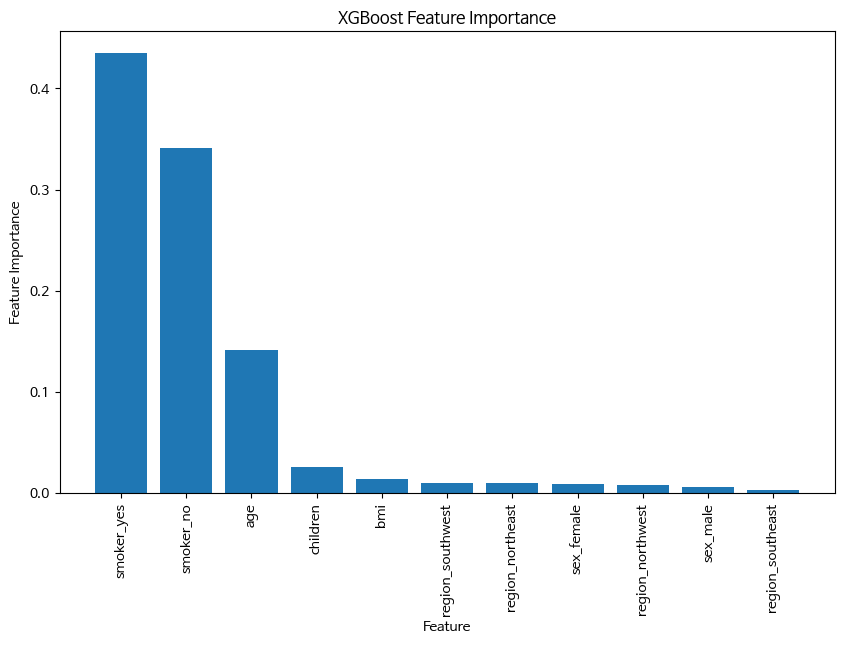

In [11]:
# 특성 중요도 시각화
feature_importances = best_xgb.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_idx], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.show()